<a href="https://colab.research.google.com/github/introspective321/ImRCIFAR/blob/main/CIFAR_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#Necessary Libraries
!pip install numpy
!pip install opencv-python
!pip install matplotlib
!pip install -U scikit-learn
!pip install pandas
!pip install seaborn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import pandas as pd

## Loading Dataset

In [2]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2024-04-20 00:58:40--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz.1’

cifar-10-python.tar 100%[===================>] 162.60M  65.8MB/s    in 2.5s    

2024-04-20 00:58:43 (65.8 MB/s) - ‘cifar-10-python.tar.gz.1’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

In [4]:
data_batch_1 = unpickle(r'cifar-10-batches-py/data_batch_1')
print(type(data_batch_1))
print("--------------------------")
print(data_batch_1.keys())
print("--------------------------")
for item in data_batch_1:
    print(item, type(data_batch_1[item]))
print("--------------------------")
print("Labels:", set(data_batch_1['labels']))

<class 'dict'>
--------------------------
dict_keys(['batch_label', 'labels', 'data', 'filenames'])
--------------------------
batch_label <class 'str'>
labels <class 'list'>
data <class 'numpy.ndarray'>
filenames <class 'list'>
--------------------------
Labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [7]:
batch_1 = unpickle('cifar-10-batches-py/data_batch_1')
batch_2 = unpickle('cifar-10-batches-py/data_batch_2')
batch_3 = unpickle('cifar-10-batches-py/data_batch_3')
batch_4 = unpickle('cifar-10-batches-py/data_batch_4')
batch_5 = unpickle('cifar-10-batches-py/data_batch_5')
test_batch =unpickle('cifar-10-batches-py/test_batch')

X_train_pixel = np.concatenate([batch_1['data'], batch_2['data'], batch_3['data'], batch_4['data'], batch_5['data']], axis=0)
y_train_pixel = np.concatenate([batch_1['labels'], batch_2['labels'], batch_3['labels'], batch_4['labels'], batch_5['labels']], axis=0)

X_test_pixel = test_batch['data']
y_test_pixel = test_batch['labels']

# Reshape the image data to its original dimensions
X_train_pixel = X_train_pixel.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
X_test_pixel = X_test_pixel.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

print(f'Training Samples: {len(X_train_pixel)}')
print(f'Testing Samples: {len(X_test_pixel)}')

Training Samples: 50000
Testing Samples: 10000


In [6]:
print(X_train_pixel[0].shape)
print(X_test_pixel[0].shape)

(32, 32, 3)
(32, 32, 3)


## Preprocessing

In [7]:
def rgb2gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Converting to grayscale
X_training_gray = [ rgb2gray(np.array(X_train_pixel[i])) for i in range(50000)]
X_testing_gray  = [ rgb2gray(np.array(X_test_pixel[i])) for i in range(10000)]

RGB along with corresponding grayscaled image



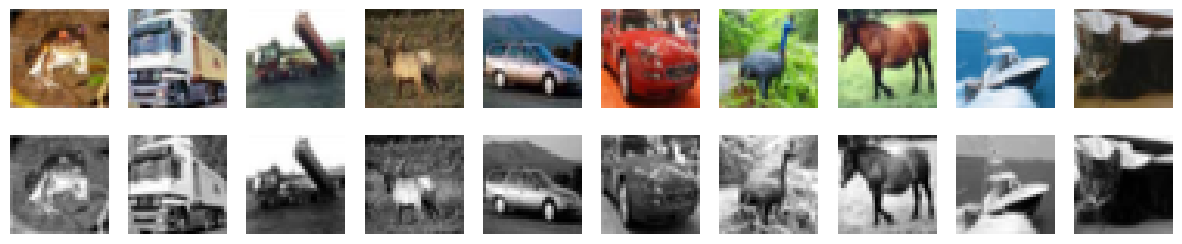

In [ ]:
%matplotlib inline

num_images = 10

plt.figure(figsize=(15, 3))
for i in range(num_images):
    # RGB image
    plt.subplot(2, num_images, i + 1)
    plt.imshow(X_train_pixel[i])
    plt.axis('off')

    # grayscale image
    plt.subplot(2, num_images, i + num_images + 1)
    plt.imshow(X_training_gray[i], cmap='gray')
    plt.axis('off')

print("RGB along with corresponding grayscaled image\n")
plt.show()

## Feature Extraction (HoGs)

In [8]:
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

def extract_hog_features(image):
    # Compute HoG features
    hog_features, hog_image = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                   cells_per_block=cells_per_block, visualize=True)

    # Rescale histogram for better visualization
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_features, hog_image_rescaled

In [9]:
X_train_HoG = []
X_train_HoG_rescaled = []
y_training = np.array(y_train_pixel)

for image in X_training_gray:
    hog_features, hog_image = extract_hog_features(image)
    X_train_HoG.append(hog_features)
    X_train_HoG_rescaled.append(hog_image)

X_training = np.array(X_train_HoG)
X_test_HoG = []
X_test_HoG_rescaled = []
y_testing = np.array(y_test_pixel)

for image in X_testing_gray:
    hog_features, hog_image = extract_hog_features(image)
    X_test_HoG.append(hog_features)
    X_test_HoG_rescaled.append(hog_image)
X_testing = np.array(X_test_HoG)

In [10]:
np.savez_compressed('X_testing_HoG_.npz', X_testing)
np.savez_compressed('X_training_HoG_.npz', X_training)
np.savez_compressed('y_training_.npz', y_training)
np.savez_compressed('y_testing_.npz', y_testing)

In [8]:
# Load the data from the compressed files
loaded_data_X_testing = np.load('X_testing_HoG_.npz')
loaded_data_X_training = np.load('X_training_HoG_.npz')
loaded_data_y_training = np.load('y_training_.npz')
loaded_data_y_testing = np.load('y_testing_.npz')

# Access the variables from the loaded data
X_testing = loaded_data_X_testing['arr_0']
X_training = loaded_data_X_training['arr_0']
y_training = loaded_data_y_training['arr_0']
y_testing = loaded_data_y_testing['arr_0']

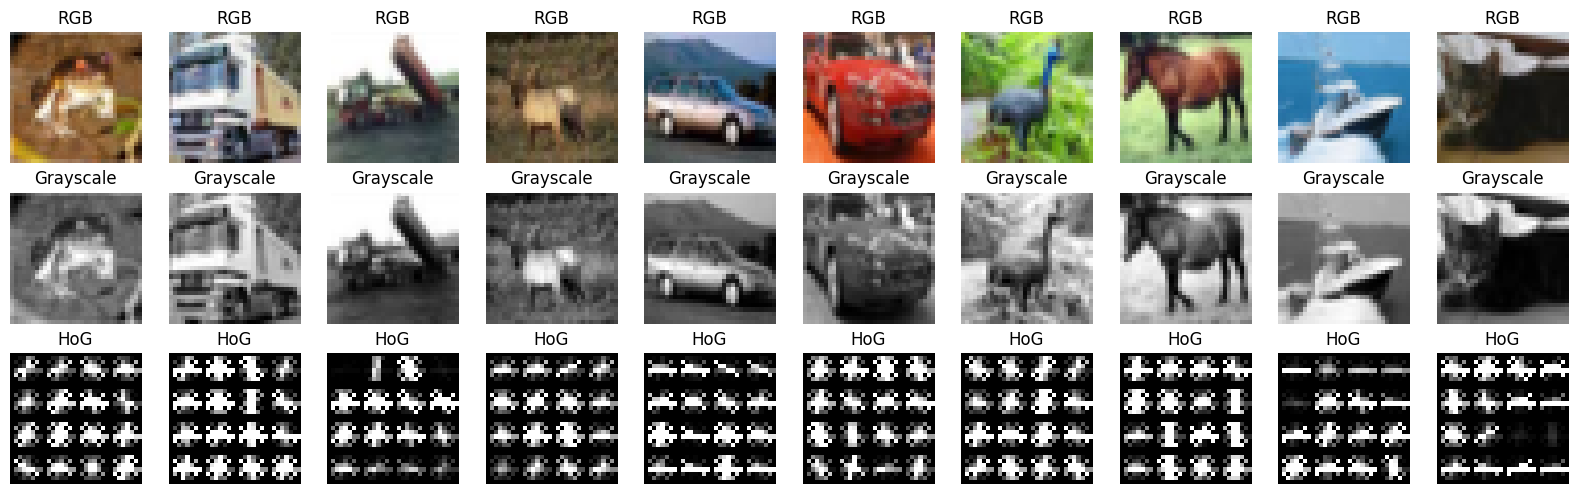

In [12]:
num_images = 10

plt.figure(figsize=(16, 5))  # Adjust the figure size to accommodate three images per row

for i in range(num_images):
    # RGB image
    plt.subplot(3, num_images, i + 1)
    plt.imshow(X_train_pixel[i])
    plt.title('RGB')
    plt.axis('off')

    # Grayscale image
    plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(X_training_gray[i], cmap='gray')
    plt.title('Grayscale')
    plt.axis('off')

    # HoG visualization
    plt.subplot(3, num_images, i + 1 + 2 * num_images)
    # Assuming X_train_HoG_rescaled contains the rescaled HoG images
    plt.imshow(X_train_HoG_rescaled[i], cmap='gray')
    plt.title('HoG')
    plt.axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

## Data Statistics

In [13]:
print( 'X_training shape is {}'.format( X_training.shape) )
print( 'y_training shape is {}'.format( y_training.shape ) )
print( 'X_testing shape is {}'.format( X_testing.shape ) )
print( 'y_testing shape is {}'.format( y_testing.shape ) )

X_training shape is (50000, 324)
y_training shape is (50000,)
X_testing shape is (10000, 324)
y_testing shape is (10000,)


In [14]:
print( 'Overview of Training Data (Features)')
pd.DataFrame( X_training ).describe()

Overview of Training Data (Features)


,0,1,2,3,4,5,6,7,8,9,...,314,315,316,317,318,319,320,321,322,323
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.137601,0.082897,0.090118,0.102097,0.171012,0.089900,0.072338,0.067848,0.077589,0.149983,...,0.097615,0.137268,0.085924,0.094136,0.116418,0.186274,0.094934,0.077149,0.074033,0.079453
std,0.095472,0.082497,0.084742,0.087668,0.101492,0.084565,0.076714,0.075014,0.085352,0.098381,...,0.092334,0.090723,0.080054,0.082016,0.090754,0.098338,0.082151,0.076954,0.076180,0.082591
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.050749,0.014953,0.020542,0.028851,0.082237,0.020243,0.011889,0.008619,0.007922,0.060562,...,0.019398,0.059121,0.021773,0.028385,0.042047,0.103639,0.028978,0.018068,0.014950,0.013872
50%,0.124834,0.057155,0.064265,0.079492,0.171004,0.065074,0.046007,0.041164,0.046652,0.145254,...,0.069572,0.122129,0.061525,0.070361,0.094241,0.191000,0.072809,0.051962,0.048510,0.051005
75%,0.226851,0.126563,0.136626,0.156967,0.254369,0.137034,0.108178,0.101114,0.119561,0.240287,...,0.153765,0.215830,0.127786,0.139650,0.176147,0.263477,0.140446,0.111715,0.108195,0.119398
max,0.628524,0.512540,0.552542,0.525049,0.682448,0.499473,0.528356,0.547740,0.493267,0.579524,...,0.545577,0.635999,0.491866,0.471242,0.527723,0.707107,0.488977,0.527286,0.468730,0.534006


In [15]:
print( 'Overview of Training Data (Target)')
pd.DataFrame( y_training ).describe()

Overview of Training Data (Target)


,0
count,50000.00000
mean,4.50000
std,2.87231
min,0.00000
25%,2.00000
50%,4.50000
75%,7.00000
max,9.00000


## K-Means Clustering (Just for the record)

In [14]:
def computeCentroid(features):
    """
    Compute centroid of a list of features.

    Parameters:
    features (numpy array): Array of features.

    Returns:
    numpy array: Centroid of the features.
    """
    num_features = len(features)
    if num_features == 0:
        return None

    # Compute mean of the features
    centroid = np.mean(features, axis=0)

    return centroid

# Convert the image_np array to a list of 3-dimensional features
features_list = X_training

# Compute the centroid of the features
centroid = computeCentroid(features_list)

def mykmeans(X, k, max_iters=100):
    # Step 1: Initialize cluster centers randomly
    np.random.seed(42)  # For reproducibility
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(max_iters):
        # Step 2: Assign each data point to the nearest cluster center
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)

        # Step 3: Update cluster centers
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.allclose(centroids, new_centroids):
            break

        centroids = new_centroids

    return centroids

# Define the function to compress the image using centroids
def compress_image_with_centroids(image, centroids):
    distances = np.sqrt(((image - centroids[:, np.newaxis])**2).sum(axis=2))
    labels = np.argmin(distances, axis=0)
    compressed_image = centroids[labels]
    return compressed_image

 # Display compressed images
    plt.figure(figsize=(16, 6))
    for i in range(10):  # Display first 10 compressed images
        plt.subplot(2, 5, i + 1)
        plt.imshow(compressed_images[i].reshape(X_training_gray[0].shape).astype(np.uint8), cmap='gray')
        plt.title('Compressed Image {}'.format(i + 1))
        plt.axis('off')

## Principal Component Analysis

In [16]:
#Standardizing
X_training_mean = np.mean(X_training, axis=0)  # Compute mean along each feature
X_training_std = np.std(X_training, axis=0)    # Compute standard deviation along each feature
X_training_scaled = (X_training - X_training_mean) / X_training_std

# Standardize the testing data using mean and std computed from training data
X_testing_scaled = (X_testing - X_training_mean) / X_training_std

# After standardization
print('X_training_scaled shape is {}'.format(X_training_scaled.shape))
print('X_testing_scaled shape is {}'.format(X_testing_scaled.shape))

print('X_training_scaled after standardization:')
print(X_training_scaled)

X_training_scaled shape is (50000, 324)
X_testing_scaled shape is (10000, 324)
X_training_scaled after standardization:
[[ 1.30303129  1.52615303  2.23499125 ...  1.97256941  0.09999164
   0.89396738]
 [ 0.44367771  0.85759425  1.04603395 ...  0.57544604  1.23669589
  -0.65262633]
 [-1.42118567 -1.00485381 -0.99941108 ... -0.77265876 -0.0516504
  -0.53133202]
 ...
 [-1.25918274 -1.00485381 -1.06345529 ...  2.59886055  2.61687397
   0.66112957]
 [-1.25145768 -1.00485381 -1.0278732  ... -0.04087711  1.59214579
   1.0408739 ]
 [-0.1189403   0.64937907 -0.15295917 ... -0.20600012  1.73986766
  -0.73048979]]


In [17]:
# Compute the covariance matrix
cov_matrix = np.cov(X_training_scaled, rowvar=False)

# Print the covariance matrix
print("Covariance matrix:")
print(cov_matrix)

Covariance matrix:
[[1.00002    0.47450196 0.21931131 ... 0.07142396 0.11198432 0.14578755]
 [0.47450196 1.00002    0.48996317 ... 0.06218371 0.09634328 0.11329057]
 [0.21931131 0.48996317 1.00002    ... 0.04492696 0.06542496 0.06409345]
 ...
 [0.07142396 0.06218371 0.04492696 ... 1.00002    0.49712666 0.22231806]
 [0.11198432 0.09634328 0.06542496 ... 0.49712666 1.00002    0.49731331]
 [0.14578755 0.11329057 0.06409345 ... 0.22231806 0.49731331 1.00002   ]]


In [18]:
# Find the eigenvectors and eigenvalues of the covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Adjusting the eigenvectors (loadings) that are largest in absolute value to be positive
max_abs_idx = np.argmax(np.abs(eigenvectors), axis=0)
signs = np.sign(eigenvectors[max_abs_idx, range(eigenvectors.shape[0])])
eigenvectors = eigenvectors * signs[np.newaxis, :]
eigenvectors = eigenvectors.T

# Print the eigenvalues and eigenvectors
print("Number of Eigenvalues:")
print(len(eigenvalues))
print("Eigenvector Matrix Shape:")
print(eigenvectors.shape)

Number of Eigenvalues:
324
Eigenvector Matrix Shape:
(324, 324)


In [19]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigenvalues[i]), eigenvectors[i, :]) for i in range(len(eigenvalues))]

# Sort the tuples from the highest to the lowest based on eigenvalues magnitude
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# For further usage
eig_vals_sorted = np.array([x[0] for x in eig_pairs])
eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

print(f'Number of Eigen-Pairs: {len(eig_pairs)}')

Number of Eigen-Pairs: 324


Explained variance and Cumulative Explained Variance have been calculated!



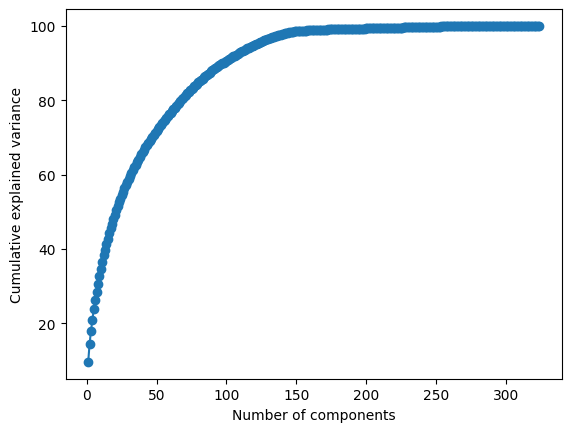

In [20]:
# Calculate explained variance and cumulative explained variance
eig_vals_total = np.sum(eig_vals_sorted)
explained_variance = [(i / eig_vals_total) * 100 for i in eig_vals_sorted]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

print('Explained variance and Cumulative Explained Variance have been calculated!\n')


# Plotting cumulative explained variance
num_components = len(explained_variance)
plt.plot(np.arange(1, num_components + 1), cum_explained_variance, '-o')

# Set x-axis tick labels explicitly
custom_ticks = [0, 50, 100, 150, 200, 250, 300]
plt.xticks(custom_ticks)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Shape of Projected Data: (50000, 130)


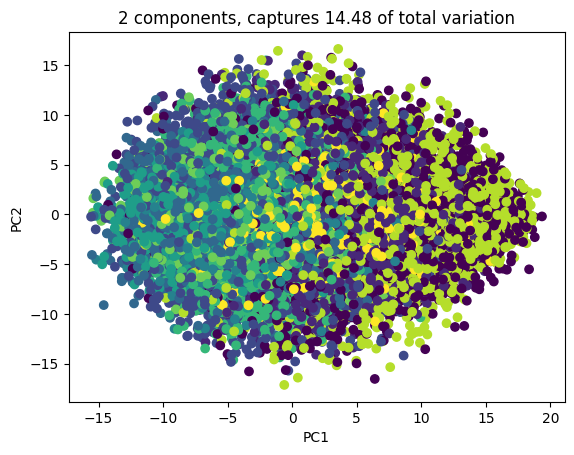

In [21]:
# Visualizing Over two components
k = 130
W = eig_vecs_sorted[:k, :]  # Projection matrix

X_proj = X_training_scaled.dot(W.T)

print(f'Shape of Projected Data: {X_proj.shape}')

plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y_training)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('2 components, captures {} of total variation'.format(cum_explained_variance[1]))
plt.show()

In [22]:
class MyPCA:

    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        # Standardize data
        X = X.copy()
        self.mean = np.mean(X, axis=0)
        self.scale = np.std(X, axis=0)
        X_std = (X - self.mean) / self.scale

        # Eigendecomposition of covariance matrix
        cov_mat = np.cov(X_std.T)
        eig_vals, eig_vecs = np.linalg.eig(cov_mat)

        # Adjusting the eigenvectors that are largest in absolute value to be positive
        max_abs_idx = np.argmax(np.abs(eig_vecs), axis=0)
        signs = np.sign(eig_vecs[max_abs_idx, range(eig_vecs.shape[0])])
        eig_vecs = eig_vecs * signs[np.newaxis, :]
        eig_vecs = eig_vecs.T

        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[i, :]) for i in range(len(eig_vals))]
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])

        self.components = eig_vecs_sorted[:self.n_components, :]

        # Explained variance ratio
        self.explained_variance_ratio = [i / np.sum(eig_vals) for i in eig_vals_sorted[:self.n_components]]

        self.cum_explained_variance = np.cumsum(self.explained_variance_ratio)

        return self

    def transform(self, X):
        X = X.copy()
        X_std = (X - self.mean) / self.scale
        X_proj = X_std.dot(self.components.T)

        return X_proj

In [23]:
my_pca = MyPCA(n_components=130).fit(X_training)

#print('Components:\n', my_pca.components)
#print('Explained variance ratio:\n', my_pca.explained_variance_ratio)
#print('Cumulative explained variance:\n', my_pca.cum_explained_variance)

X_train_pca = my_pca.transform(X_training)
X_test_pca = my_pca.transform(X_testing)
print('Transformed train data shape:', X_train_pca.shape)
print('Transformed test data shape:', X_test_pca.shape)

np.savez_compressed('X_testing_pca.npz', X_test_pca)
np.savez_compressed('X_training_pca.npz', X_train_pca)

Transformed train data shape: (50000, 130)
Transformed test data shape: (10000, 130)


## Load Feature and Target Variables directly from compressed files

In [6]:
# Load the data from the compressed files
loaded_data_X_testing_pca = np.load('X_testing_pca.npz')
loaded_data_X_training_pca = np.load('X_training_pca.npz')
loaded_data_y_training = np.load('y_training_.npz')
loaded_data_y_testing = np.load('y_testing_.npz')

# Access the variables from the loaded data
X_test_pca = loaded_data_X_testing_pca['arr_0']
X_train_pca = loaded_data_X_training_pca['arr_0']
y_training = loaded_data_y_training['arr_0']
y_testing = loaded_data_y_testing['arr_0']

## MultiClass Single Layer Perceptron

In [ ]:
# Train perceptron
def initialize_weights(num_features):
    return np.random.uniform(-1, 1, size=num_features + 1)

def perceptron_train(X_train, y_train, iterations, learning_rate, num_classes):
    num_features = X_train.shape[1]
    weights = []

    for class_label in range(num_classes):
        class_weights = initialize_weights(num_features)
        for _ in range(iterations):
            # Shuffle data for each epoch
            shuffled_indices = np.random.permutation(len(X_train))
            X_train_shuffled = X_train[shuffled_indices]
            y_train_shuffled = y_train[shuffled_indices]
            for features, label in zip(X_train_shuffled, y_train_shuffled):
                features_with_bias = np.insert(features, 0, 1)
                target = 1 if label == class_label else 0
                prediction = 1 if np.dot(class_weights, features_with_bias) >= 0 else 0
                error = target - prediction
                class_weights += learning_rate * error * features_with_bias
        weights.append(class_weights)

    return weights

# Training perceptron
weights = perceptron_train(X_training, y_training, iterations=50, learning_rate=0.001, num_classes=10)


In [ ]:
# Make predictions
def predict(X_test, weights):
    predictions = []
    for sample in X_test:
        scores = [np.dot(sample, class_weights[1:]) + class_weights[0] for class_weights in weights]
        predicted_label = np.argmax(scores)
        predictions.append(predicted_label)
    return np.array(predictions)

predicted_labels = predict(X_testing, weights)

# Compute accuracy
accuracy = np.mean(predicted_labels == y_testing)
print("Accuracy:", accuracy)

Accuracy: 0.3568


## Logistic Reg

In [3]:
class LogisticRegMultiClass:
    def __init__(self, lr=0.001, iter=1000):
        self.lr = lr
        self.iter = iter
        self.weights = None
        self.bias = None
        self.loss = []

    # Sigmoid function
    def sigmoid_(self, x):
        return 1 / (1 + np.exp(-x))

    # Binary Cross Entropy Loss function
    # Binary Cross Entropy Loss function
    # Inside the loss_compute method
    def loss_compute(self, y_actual, y_pred):
        eps = 1e-9
        y_actual_one_hot = np.eye(y_pred.shape[1])[y_actual]  # One-hot encode y_actual
        loss = -np.mean(y_actual_one_hot * np.log(y_pred + eps) + (1 - y_actual_one_hot) * np.log(1 - y_pred + eps))
        return loss



    # Feedforward function
    def feedforward(self, X):
        z = self.bias + np.dot(X, self.weights)
        A_ = self.sigmoid_(z)
        return A_

    # Fit function
    def fit(self, X, y):
        num_samples, num_features = X.shape
        num_classes = np.unique(y).size

        self.weights = np.zeros((num_features, num_classes))
        self.bias = np.zeros(num_classes)

        # Gradient Descent
        for _ in range(self.iter):
            A_ = self.feedforward(X)  # Calculate predictions for all classes
            self.loss.append(self.loss_compute(y, A_))  # Compute loss for all classes
            dz = A_ - np.eye(num_classes)[y]  # derivative of sigmoid and BCE
            # Gradients
            dw = (1 / num_samples) * np.dot(X.T, dz)
            db = (1 / num_samples) * np.sum(dz, axis=0)
            # Updating parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    # Predict function
    def predict(self, X):
        y_h = self.bias + np.dot(X, self.weights)
        y_pred_prob = self.sigmoid_(y_h)
        y_pred_class = np.argmax(y_pred_prob, axis=1)
        return y_pred_class

In [ ]:
logistic_regressor = LogisticRegMultiClass(lr=0.0001, iter=1000)
logistic_regressor.fit(X_train_pca, y_training)
preds = logistic_regressor.predict(X_test_pca)

In [ ]:
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_testing, preds)*100}%')

Accuracy: 40.26%


## K-Nearest Neighbour

In [7]:
#Calculating Euclidean distance
def euclidean_dist(pointA, pointB):

    distance = np.sqrt(np.sum(np.square(pointA - pointB))) #Vectorization
    return distance

#Calculating distance of test point from all the training points
def distance_from_all_training_points(test_point, train_features):
#Returns- dist_array- Array holding distance values for all training data points
    dist_array = np.array([euclidean_dist(test_point, train_point) for train_point in train_features])
    return dist_array

#Implementing KNN Classification model
def KNNClassifier(train_features, train_target, test_features, k):
    predictions = np.array([])
    train_target = train_target.reshape(-1,1)

    for test_point in test_features:
        dist_array = distance_from_all_training_points(test_point, train_features)
        neighbors = np.concatenate((dist_array.reshape(-1, 1), train_target), axis=1)
        neighbors_sorted = neighbors[neighbors[:, 0].argsort()]
        k_neighbors = neighbors_sorted[:k]
        nearest_classes = k_neighbors[:, 1].astype(int)
        target_class = np.argmax(np.bincount(nearest_classes))
        predictions = np.append(predictions, target_class)

    return np.array(predictions)

In [8]:
#running inference on test data
test_predictions = KNNClassifier(X_train_pca, y_training, X_test_pca, 3)
test_predictions

array([4., 8., 1., ..., 2., 2., 7.])

In [9]:
from sklearn.metrics import classification_report
#Model Evaluation
def accuracy(y_test, y_preds):
    total_correct = sum(1 for true, pred in zip(y_test, y_preds) if true == pred)
    acc = total_correct / len(y_test)
    return acc
acc = accuracy(y_testing, test_predictions)
print('Model accuracy (Scratch) = ', acc*100)
print("Score:\n", classification_report(y_testing, test_predictions))

Model accuracy (Scratch) =  46.92
Score:
               precision    recall  f1-score   support

           0       0.57      0.57      0.57      1000
           1       0.58      0.69      0.63      1000
           2       0.33      0.43      0.37      1000
           3       0.32      0.23      0.27      1000
           4       0.28      0.48      0.35      1000
           5       0.49      0.25      0.33      1000
           6       0.42      0.69      0.52      1000
           7       0.73      0.40      0.52      1000
           8       0.69      0.49      0.58      1000
           9       0.71      0.45      0.55      1000

    accuracy                           0.47     10000
   macro avg       0.51      0.47      0.47     10000
weighted avg       0.51      0.47      0.47     10000



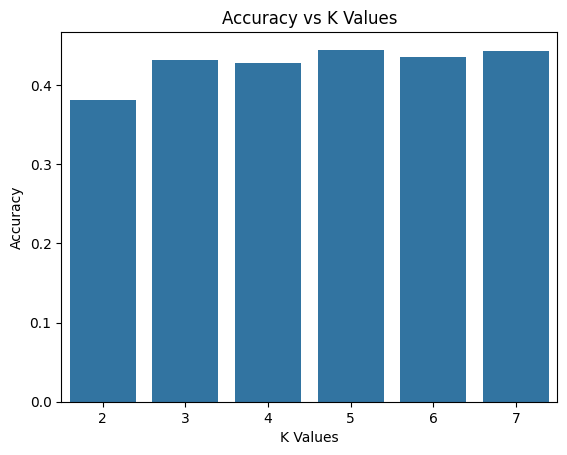

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

k_values = list(range(2, 8))
accuracy_list = []

# Assuming KNNClassifier and accuracy functions are defined/imported correctly
for k in k_values:
    test_predictions = KNNClassifier(X_train_pca[:10000], y_training[:10000], X_test_pca[:2000], k)
    accuracy_list.append(accuracy(y_testing[:2000], test_predictions))

sns.barplot(x=k_values, y=accuracy_list)
plt.xlabel('K Values')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K Values')
plt.show()

## Naive Bayes

There are 10 classes and 130 features in pca reduced dataset. This accounts to more than 1300 likelihood probabilities. Hence, implementing this algorithm manually from scratch is cumbersome. All three Naive Bayes classifier types(Gaussian, Multinomial, Bernoulli) are implemented in the cells below using Sklearn.

In [ ]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
print(X_train_pca.shape)
print(X_test_pca.shape)

(50000, 130)
(10000, 130)


In [ ]:
# initializing the classifiers
clf1 = GaussianNB()
clf2 = MultinomialNB()
clf3 = BernoulliNB()
from sklearn.metrics import accuracy_score
import time

In [ ]:
#Implementing Gaussian Naive Bayes Classifier
try:
  start = time.time()
  clf1.fit(X_train_pca,y_training)
  end = time.time()
  print(f'time taken : {end - start}')

  y_pred1 = clf1.predict(X_test_pca)
  print(y_pred1.shape)
  print(accuracy_score(y_testing,y_pred1))

except Exception as e:
  print(f'Some error occurred : {e}')

time taken : 0.07718133926391602
(10000,)
0.4923


In [ ]:
# Implementing Multinomial Naive Bayes Classifier

try:
  start = time.time()
  clf2.fit(X_train_pca,y_training)
  end = time.time()
  print(f'time taken : {end - start}')

  y_pred2 = clf2.predict(X_test_pca)
  print(y_pred2.shape)
  print(accuracy_score(y_testing,y_pred2))

except Exception as e:
  print(f'Some error occurred : {e}')

Some error occurred : Negative values in data passed to MultinomialNB (input X)


In [ ]:
negatives = (X_train_pca < 0).sum().sum()

print(f"Total count of negative values : {negatives} Percentage : {(negatives / (50000*130))*100}")

Total count of negative values : 3252025 Percentage : 50.03115384615384


Since a high fraction of values are negative, manipulating this dataset to handle negative values is not a good deal.

In [ ]:
# Implementing Bernoulli Naive Bayes Classifier

try:
  start = time.time()
  clf3.fit(X_train_pca,y_training)
  end = time.time()
  print(f'time taken : {end - start}')

  y_pred3 = clf3.predict(X_test_pca)
  print(y_pred3.shape)
  print(accuracy_score(y_testing,y_pred3))

except Exception as e:
  print(f'Some error occurred : {e}')

time taken : 0.145125150680542
(10000,)
0.3985


**Verdict on Naive Bayes**

Given that the dataset is so feature and classes enriched, Multinomial NB could be an appropriate classifier but it does not take negative values which has resulted into an error as stated above. Moreover, there are 10 classes while Bernoulli is used for binary classification. Hence, Naive Bayes is not an ideal classifier for this dataset.

## Ensemble Learning

### Decision Tree

In [55]:
import numpy as np
from collections import Counter
import random
import multiprocessing as mp
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets

def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    en = -np.sum([p*np.log2(p) for p in ps if p>0])
    return en

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_sample_split=2, max_depth=100, max_features=None):
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.root = None

    def fit(self, X, y):
        self.max_features = X.shape[1] if self.max_features is None else min(self.max_features, X.shape[1])
        self.root = self._grow_tree(X, y)

    # Add your _grow_tree, _best_criteria, _split, _most_common_label, and prune methods here
    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_sample_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.max_features, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, self.max_features)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def _best_criteria(self, X, y, max_features):
        """
        Find the best split for a node.
        """
        # Ensure that max_features is an integer
        max_features = int(max_features)

        # Randomly select a subset of the features without replacement
        feat_idxs = random.sample(range(X.shape[1]), max_features)

        best_feat, best_thresh = None, None
        best_gain = -1
        for feature in feat_idxs:
            X_column = X[:, feature]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    best_feat = feature
                    best_thresh = threshold

        return best_feat, best_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def prune(self, X_val, y_val):

        self.accuracy_with_child = np.sum(self.predict(X_val) == y_val) / len(y_val)
        self._prune(self.root, X_val, y_val)

    def _prune(self, node, X_val, y_val):
        """
        Recursively prune the tree.
        """
        if node is None or node.is_leaf_node():
            return

        if node.left:
            if node.left.is_leaf_node():
                self._try_prune(node, 'left', X_val, y_val)
            else:
                self._prune(node.left, X_val, y_val)

        if node.right:
            if node.right.is_leaf_node():
                self._try_prune(node, 'right', X_val, y_val)
            else:
                self._prune(node.right, X_val, y_val)

    def _try_prune(self, node, child_side, X_val, y_val):
        """
        Try to prune a child of a node and check if it improves the accuracy.
        """
        child_node = getattr(node, child_side)
        setattr(node, child_side, None)

        y_pred = self.predict(X_val)
        accuracy_without_child = np.sum(y_val == y_pred) / len(y_val)

        setattr(node, child_side, child_node)

        if accuracy_without_child >= self.accuracy_with_child:
            setattr(node, child_side, None)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node is None:
            return None

        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)

        return self._traverse_tree(x, node.right)

### Random Forest

In [33]:
class RandomForestClassifer:
    def __init__(self, n_estimator=100, min_sample_split=2, max_depth=10, max_features=None):
        self.n_estimator = n_estimator
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []

        # Create a pool of processes
        with mp.Pool(processes=mp.cpu_count()) as pool:

            # Define the arguments for each process
            args = [(X, y) for _ in range(self.n_estimator)]

            # Use starmap to apply the function to each set of arguments
            self.trees = pool.starmap(self._train_tree, args)

    def _train_tree(self, X, y):
        tree = DecisionTree(min_sample_split=self.min_sample_split, max_depth=self.max_depth, max_features=self.max_features)
        X_sample, y_sample = bootstrap_sample(X, y)
        tree.fit(X_sample, y_sample)
        return tree

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

    def prune(self, X_val, y_val):
        for tree in self.trees:
            tree.prune(X_val, y_val)

def bootstrap_sample(X,y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples , size=n_samples,replace = True)
    return X[idxs],y[idxs]

def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]  # Get the label, not the count
    return most_common

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [15]:
# Reshape the training and testing data
X_train_hog_flat = X_training.reshape(len(X_training), -1)
X_test_hog_flat = X_testing.reshape(len(X_testing), -1)

In [64]:
# Train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=5, max_depth=5, max_features=10)
rf_classifier.fit(X_train_hog_flat, y_training)

# Evaluate model
y_pred = rf_classifier.predict(X_test_hog_flat)
acc = accuracy(y_testing, y_pred)
print(f"Accuracy: {acc*100} %")


Accuracy: 33.0 %


Analyzing how the accuracy varies with the three factors (max_depth, n_estimators, max_features) to find best parameters and visualizing the results. (SKlearn)

Best parameters: {'max_depth': 10, 'max_features': 15, 'n_estimators': 10}
Best accuracy score: 0.40168


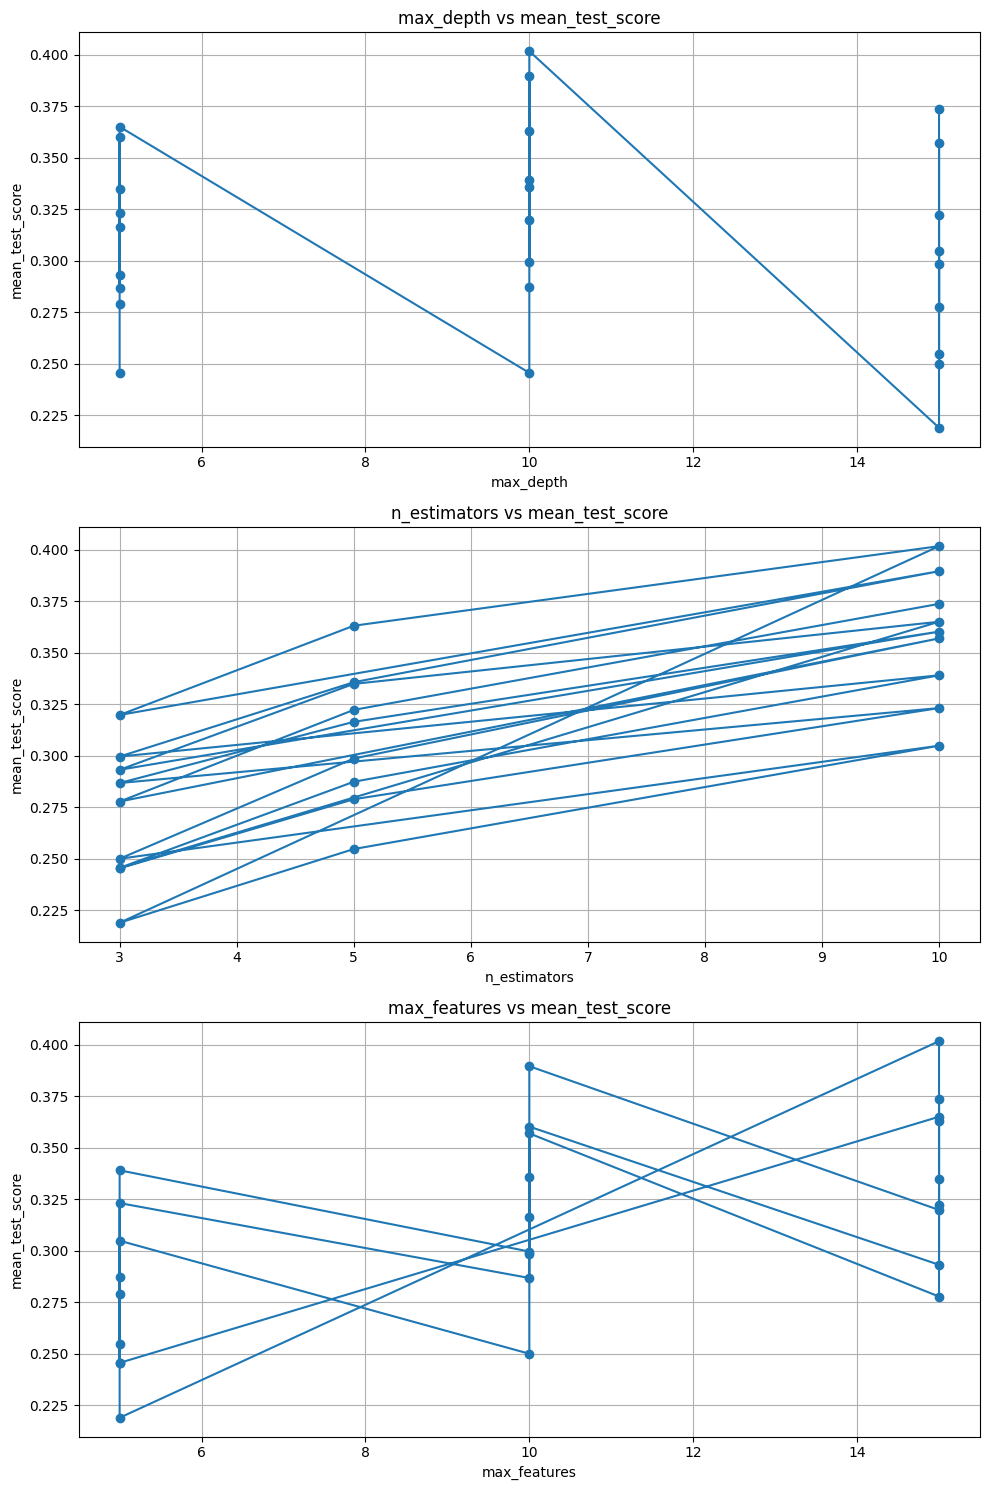

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'max_depth': [5, 10, 15],
    'n_estimators': [3, 5, 10],
    'max_features': [5, 10, 15]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model (assuming X_train_hog_flat and y_training are defined)
grid_search.fit(X_train_hog_flat, y_training)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best accuracy score: {best_score}")

# Convert the grid search results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Create a figure and axes for subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot the mean test score for each value of 'max_depth'
axs[0].plot(results['param_max_depth'], results['mean_test_score'], marker='o')
axs[0].set_title('max_depth vs mean_test_score')
axs[0].set_xlabel('max_depth')
axs[0].set_ylabel('mean_test_score')
axs[0].grid(True)

# Plot the mean test score for each value of 'n_estimators'
axs[1].plot(results['param_n_estimators'], results['mean_test_score'], marker='o')
axs[1].set_title('n_estimators vs mean_test_score')
axs[1].set_xlabel('n_estimators')
axs[1].set_ylabel('mean_test_score')
axs[1].grid(True)

# Plot the mean test score for each value of 'max_features'
axs[2].plot(results['param_max_features'], results['mean_test_score'], marker='o')
axs[2].set_title('max_features vs mean_test_score')
axs[2].set_xlabel('max_features')
axs[2].set_ylabel('mean_test_score')
axs[2].grid(True)

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()

## SVM Classifier

### Sklearn

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

# Reshape the data
X_train_hog_flat = X_train_pca.reshape(len(X_train_pca), -1)
X_test_hog_flat = X_test_pca.reshape(len(X_test_pca), -1)

# Train SVM classifier
svm_classifier = svm.SVC(kernel='rbf')  # You can change the kernel as needed
svm_classifier.fit(X_train_hog_flat, y_training)

# Evaluate model
y_pred = svm_classifier.predict(X_test_hog_flat)
acc = accuracy_score(y_testing, y_pred)
print("Accuracy:", acc)

Accuracy: 0.6189


### Scratch Implementation with Hyperparameters tuning


In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

class SVM(object):
    def __init__(self, kernel, C, learning_rate, lambda_param, n_iters, gamma, degree):
        self.kernel = kernel
        self.C = C
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.gamma = gamma
        self.degree = degree
        self.w = None
        self.b = None

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self, x, y):
        return (np.dot(x, y) + 1) ** self.degree

    def gaussian_kernel(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

    def kernel_function(self, x, y):
        if self.kernel == 'linear':
            return self.linear_kernel(x, y)
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x, y)
        elif self.kernel == 'gaussian':
            return self.gaussian_kernel(x, y)
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        self.alphas = np.zeros(n_samples)
        self.sv = None
        self.sv_y = None

        for _ in range(self.n_iters):
            for idx in range(n_samples):
                x_i = X[idx]
                y_i = y_[idx]
                Xw_b_i = np.dot(x_i, self.w) - self.b

                condition = y_i * Xw_b_i >= 1
                if not condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_i))
                    self.b += self.lr * y_i
                    self.alphas[idx] += self.lr
            # Store support vectors and coefficients
            idx_support = self.alphas > 0
            self.sv = X[idx_support]
            self.sv_y = y_[idx_support]


    def predict(self, X):
        return np.sign(self.project(X))

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.alphas, self.sv_y, self.sv):
                    if self.kernel == 'linear':
                        s += a * sv_y * self.linear_kernel(X[i], sv)
                    elif self.kernel == 'polynomial':
                        s += a * sv_y * self.polynomial_kernel(X[i], sv)
                    elif self.kernel == 'gaussian':
                        s += a * sv_y * self.gaussian_kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def kernel_matrix(self, X1, X2):
        n_samples1, _ = X1.shape
        n_samples2, _ = X2.shape
        kernel_matrix = np.zeros((n_samples1, n_samples2))
        for i in range(n_samples1):
            for j in range(n_samples2):
                kernel_matrix[i, j] = self.kernel_function(X1[i], X2[j])
        return kernel_matrix

In [ ]:
# Load your dataset
# X_train, y_train, X_test, y_test = ...
# Reshape the data
X_train_hog_flat = X_train_pca.reshape(len(X_train_pca), -1)
X_test_hog_flat = X_test_pca.reshape(len(X_test_pca), -1)


# Tune parameters (replace this with your own tuning function)
def tune_parameters(X, y):
    param_grid = {'C': [0.1, 1, 10, 100],
                  'gamma': [0.001, 0.01, 0.1, 1],
                  'kernel': ['rbf']}
    svm_grid = GridSearchCV(SVC(), param_grid, cv=5)
    svm_grid.fit(X, y)
    best_params = svm_grid.best_params_
    return best_params

# Tune parameters
best_params = tune_parameters(X_train_hog_flat[:1000], y_training[:1000])
print("Best parameters:", best_params)

In [ ]:
X_train_hog_flat = X_train_pca.reshape(len(X_train_pca), -1)
X_test_hog_flat = X_test_pca.reshape(len(X_test_pca), -1)

In [ ]:
best_params['C'] = 1
best_params['gamma'] = 0.01

In [ ]:
import numpy as np

# Initialize and train the SVM model
svm = SVM(kernel=best_params['kernel'], C=best_params['C'], learning_rate=0.01, lambda_param=0.01, n_iters=1000, gamma=best_params['gamma'], degree=3)
svm.fit(X_train_hog_flat, y_training)

# Evaluate the model
y_pred = svm.predict(X_test_hog_flat)
acc = accuracy_score(y_testing, y_pred)
print("Accuracy:", acc)

Accuracy: 0.1


Checking the accuracy of the model on some other Synthtic Dataset with 50000 points and noise = 20 %. (For the above failure case analysis)

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

class SVM(object):
    def __init__(self, kernel='linear', C=1, learning_rate=0.001, lambda_param=0.01, n_iters=1000, gamma=1, degree=3):
        self.kernel = kernel
        self.C = C
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.gamma = gamma
        self.degree = degree
        self.w = None
        self.b = None

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def polynomial_kernel(self, x, y):
        return (np.dot(x, y) + 1) ** self.degree

    def gaussian_kernel(self, x, y):
        return np.exp(-self.gamma * np.linalg.norm(x - y) ** 2)

    def kernel_function(self, x, y):
        if self.kernel == 'linear':
            return self.linear_kernel(x, y)
        elif self.kernel == 'polynomial':
            return self.polynomial_kernel(x, y)
        elif self.kernel == 'gaussian':
            return self.gaussian_kernel(x, y)
        else:
            raise ValueError("Unsupported kernel type")

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx in range(n_samples):
                x_i = X[idx]
                y_i = y_[idx]
                Xw_b_i = np.dot(x_i, self.w) - self.b

                condition = y_i * Xw_b_i >= 1
                if not condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_i))
                    self.b += self.lr * y_i

    def predict(self, X):
        return np.sign(self.project(X))

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.alphas, self.sv_y, self.sv):
                    if self.kernel == 'linear':
                        s += a * sv_y * self.linear_kernel(X[i], sv)
                    elif self.kernel == 'polynomial':
                        s += a * sv_y * self.polynomial_kernel(X[i], sv)
                    elif self.kernel == 'gaussian':
                        s += a * sv_y * self.gaussian_kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b

    def kernel_matrix(self, X1, X2):
        n_samples1, _ = X1.shape
        n_samples2, _ = X2.shape
        kernel_matrix = np.zeros((n_samples1, n_samples2))
        for i in range(n_samples1):
            for j in range(n_samples2):
                kernel_matrix[i, j] = self.kernel_function(X1[i], X2[j])
        return kernel_matrix

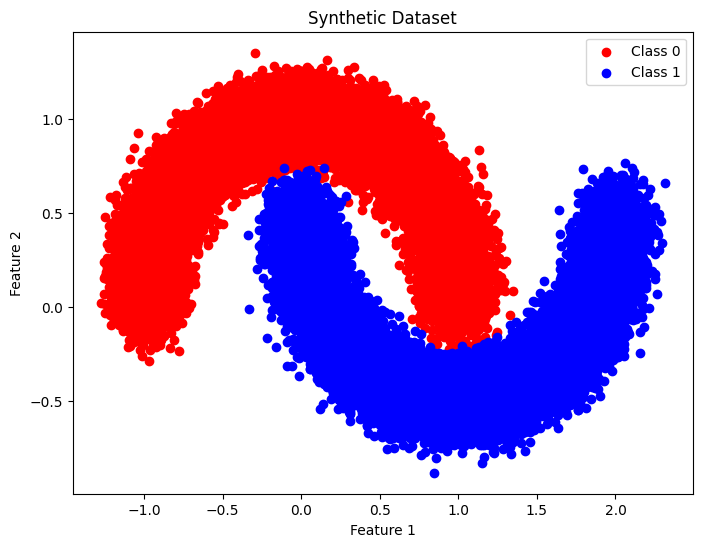

Shape of X: (50000, 2)
Shape of y: (50000,)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate synthetic dataset
X, y = make_moons(n_samples=50000, noise=0.1, random_state=42)

# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Class 1')
plt.title('Synthetic Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Print the shape of the data
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform hyperparameter tuning with GridSearchCV for each kernel
param_grids = {
    'linear': {'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
    'poly': {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['poly']},
    'rbf': {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']}
}

best_accuracies = {}

for kernel, param_grid in param_grids.items():
    svm_grid = GridSearchCV(SVC(), param_grid, cv=5)
    svm_grid.fit(X_train, y_train)
    best_params = svm_grid.best_params_
    best_accuracy = svm_grid.best_score_
    best_accuracies[kernel] = (best_params, best_accuracy)

# Print best parameters and accuracies for each kernel
for kernel, (best_params, best_accuracy) in best_accuracies.items():
    print(f"Best parameters for {kernel} kernel:", best_params)
    print(f"Best accuracy for {kernel} kernel:", best_accuracy)

Best parameters for linear kernel: {'C': 1, 'kernel': 'linear'}
Best accuracy for linear kernel: 0.8815250000000001
Best parameters for poly kernel: {'C': 100, 'gamma': 1, 'kernel': 'poly'}
Best accuracy for poly kernel: 0.9328749999999999
Best parameters for rbf kernel: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best accuracy for rbf kernel: 0.9996


## Multilayer Perceptron

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

#MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Hyperparameters
input_size = 130  # Input features
hidden_size = 128  # Hidden layer
output_size = 10  # NOutput Classes

# Instance
model = MLP(input_size, hidden_size, output_size)

# CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# NumPy arrays to PyTorch tensors
X_train_tensor = torch.Tensor(X_train_pca)
y_train_tensor = torch.Tensor(y_training).long()
X_test_tensor = torch.Tensor(X_test_pca)
y_test_tensor = torch.Tensor(y_testing).long()

# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Training
num_epochs = 20
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)

# Accuracy
accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
print(f'Test Accuracy: {accuracy:.4f}')


Epoch [1/20], Loss: 1.5379
Epoch [2/20], Loss: 1.3610
Epoch [3/20], Loss: 1.0601
Epoch [4/20], Loss: 1.3355
Epoch [5/20], Loss: 1.3748
Epoch [6/20], Loss: 1.3779
Epoch [7/20], Loss: 1.5043
Epoch [8/20], Loss: 0.9277
Epoch [9/20], Loss: 1.2497
Epoch [10/20], Loss: 1.0766
Epoch [11/20], Loss: 0.7170
Epoch [12/20], Loss: 1.0398
Epoch [13/20], Loss: 1.3389
Epoch [14/20], Loss: 1.6056
Epoch [15/20], Loss: 1.1935
Epoch [16/20], Loss: 0.8228
Epoch [17/20], Loss: 1.4386
Epoch [18/20], Loss: 0.6620
Epoch [19/20], Loss: 0.9773
Epoch [20/20], Loss: 0.8076
Test Accuracy: 0.5855
